In [95]:
#!/usr/bin/env python3
"""
Download TCGA-BRCA raw RNA-seq counts for three subtypes.
Using Recount3 which provides raw counts.
"""
import pandas as pd
import numpy as np
import requests
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from tqdm import tqdm
import torch.nn.functional as F
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
from pyro.infer import Predictive, SVI, Trace_ELBO, TraceEnum_ELBO
from pyro.optim import Adam

assert pyro.__version__.startswith('1.9.1')
pyro.set_rng_seed(0)

In [13]:
rawcounts = pd.read_csv("./GSE99116_raw_counts_GRCh38.p13_NCBI.tsv", sep="\t")
rawcounts.head()

,GeneID,GSM2633613,GSM2633614,GSM2633615,GSM2633616,GSM2633617,GSM2633618,GSM2633619,GSM2633620,GSM2633621,...,GSM2633723,GSM2633724,GSM2633725,GSM2633726,GSM2633727,GSM2633728,GSM2633729,GSM2633730,GSM2633731,GSM2633732
0,100287102,11,16,8,21,17,21,12,15,0,...,2,1,2,3,2,2,3,1,2,0
1,653635,82,93,55,105,111,95,85,86,79,...,160,42,121,108,113,123,128,100,102,29
2,102466751,3,5,2,3,4,2,4,2,3,...,5,2,1,1,2,4,4,2,3,0
3,107985730,1,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,100302278,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
rawcounts.describe()

,GeneID,GSM2633613,GSM2633614,GSM2633615,GSM2633616,GSM2633617,GSM2633618,GSM2633619,GSM2633620,GSM2633621,...,GSM2633723,GSM2633724,GSM2633725,GSM2633726,GSM2633727,GSM2633728,GSM2633729,GSM2633730,GSM2633731,GSM2633732
count,3.937600e+04,39376.000000,39376.000000,39376.000000,39376.000000,39376.000000,39376.000000,39376.000000,39376.000000,39376.000000,...,39376.000000,39376.000000,39376.000000,39376.000000,39376.000000,39376.000000,39376.000000,39376.000000,39376.000000,39376.000000
mean,4.441428e+07,197.830354,202.846785,126.069560,228.896206,207.815675,225.208706,192.238775,188.881044,198.052011,...,253.654993,102.424751,234.813694,230.508533,231.012165,290.158929,264.313008,269.467925,173.041116,59.400549
std,5.159676e+07,1365.810149,1481.634197,1036.636338,1767.606756,1498.537689,1702.690237,1382.624522,1367.964939,1156.229190,...,1776.882715,1742.857261,1561.443961,1558.417540,1515.427520,1997.945932,1569.632999,1928.250914,1253.323913,968.753602
min,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.878250e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.764545e+05,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
75%,1.053697e+08,83.000000,90.000000,55.000000,101.000000,90.000000,98.000000,85.000000,84.000000,78.000000,...,97.000000,20.000000,94.000000,91.000000,96.000000,114.000000,109.000000,103.000000,65.000000,10.000000
max,1.156947e+08,141196.000000,155939.000000,110428.000000,189958.000000,147811.000000,180599.000000,144145.000000,141983.000000,84508.000000,...,135022.000000,269652.000000,110018.000000,108544.000000,105346.000000,144320.000000,107214.000000,141644.000000,102537.000000,141020.000000


# Filtering and Processing Data

Now we are going tof ilter out genes that are almost entirely zero because we dont want to model these.
We are also going to run a quick PCA to look at clustering with a very simple normalization.

Finally at the end we will compare our clusters with the data that exists to see whether there really are different clusters that align with the data labels.

In [459]:
gene_ids = rawcounts["GeneID"]
final_counts = rawcounts.iloc[:,1:]
final_counts.head()

,GSM2633613,GSM2633614,GSM2633615,GSM2633616,GSM2633617,GSM2633618,GSM2633619,GSM2633620,GSM2633621,GSM2633622,...,GSM2633723,GSM2633724,GSM2633725,GSM2633726,GSM2633727,GSM2633728,GSM2633729,GSM2633730,GSM2633731,GSM2633732
0,11,16,8,21,17,21,12,15,0,1,...,2,1,2,3,2,2,3,1,2,0
1,82,93,55,105,111,95,85,86,79,83,...,160,42,121,108,113,123,128,100,102,29
2,3,5,2,3,4,2,4,2,3,1,...,5,2,1,1,2,4,4,2,3,0
3,1,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [460]:
# Filter genes - remove low expression
gene_sums = final_counts.sum(axis=1)
keep_genes = gene_sums > 100  # At least 100 total counts
final_counts = final_counts.loc[ keep_genes,: ]
print(f"Filtered to {final_counts.shape[0]} genes")
final_counts.shape

Filtered to 22687 genes


(22687, 119)

In [461]:
# Quick visualization
log_counts = np.log2(final_counts + 1)
#top_var_genes = log_counts.var(axis=1).nlargest(5000).index
gene_ids[top_var_genes]
max(top_var_genes)

39335

/var/folders/tp/_0ggpj0j1939tx8lym1zrbsr0000gn/T/ipykernel_6234/153153990.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


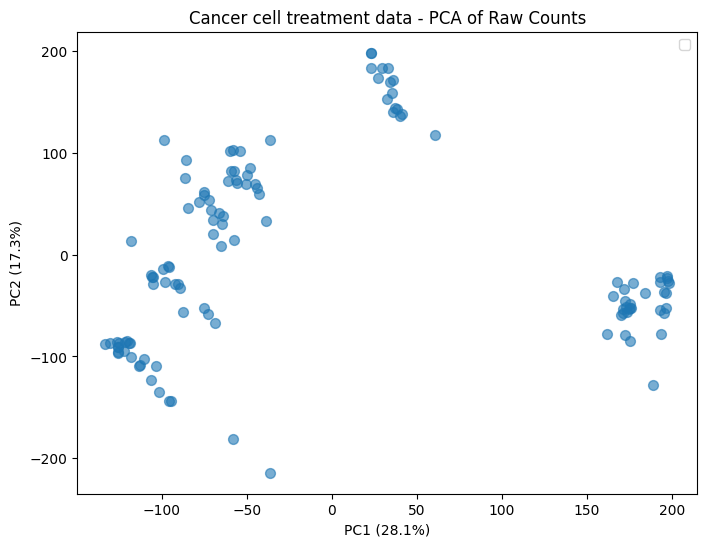

In [462]:
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(log_counts.T)

plt.figure(figsize=(8, 6))

plt.scatter(pca_coords[:,0], pca_coords[:,1], 
                alpha=0.6, s=50)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.title('Cancer cell treatment data - PCA of Raw Counts')
plt.legend()
plt.show()

In [468]:
def stick_breaking(beta):
    """Convert stick-breaking proportions to mixture weights."""
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)


def model(data, T=20, alpha=1.0):
    N, G = data.shape
    with pyro.plate("beta_plate", T-1):
        beta = pyro.sample("beta", dist.Beta(1, alpha))

    gene_plate = pyro.plate("gene_plate", G, dim=-1)
    cluster_plate = pyro.plate("cluster_plate", T, dim=-2)
    with cluster_plate:
        with gene_plate:
            mu = pyro.sample("mu", dist.LogNormal(0, 2))
            total_count = pyro.sample("total_count", dist.Gamma(2, 0.5))
            gate = pyro.sample("gate", dist.Beta(1, 5))
    
    with pyro.plate("data", N, dim=-2) as data_idx:
        z = pyro.sample("z", dist.Categorical(stick_breaking(beta)))
                        #infer={"enumerate": "sequential"})

        with gene_plate as gene_idx:
            mu_z = mu[z].squeeze()
            total_count_z = total_count[z].squeeze()
            gate_z = gate[z].squeeze()

            pyro.sample("obs", 
                       dist.ZeroInflatedNegativeBinomial(
                           total_count=total_count_z,
                           probs=total_count_z / (total_count_z + mu_z),
                           gate=gate_z),
                       obs=data)
            

In [469]:
def model_poisson(data, T=20, alpha=1.0):
    N, G = data.shape
    
    with pyro.plate("beta_plate", T-1):
        beta = pyro.sample("beta", dist.Beta(1, alpha))
    
    gene_plate = pyro.plate("gene_plate", G, dim=-1)
    cluster_plate = pyro.plate("cluster_plate", T, dim=-2)
    
    with cluster_plate:
        with gene_plate:
            mu = pyro.sample("mu", dist.Gamma(0.5, 0.005))
    
    with pyro.plate("data", N, dim=-2):
        z = pyro.sample("z", dist.Categorical(stick_breaking(beta)))
        
        with gene_plate:
            mu_z = mu[z].squeeze()
            
            # Simple Poisson observation model
            pyro.sample("obs", 
                       dist.Poisson(mu_z),
                       obs=data)
            

In [484]:
#def model_gaussian(data, T=20, alpha=1.0):
#    N, G = data.shape
#    
#    with pyro.plate("beta_plate", T-1):
#        beta = pyro.sample("beta", dist.Beta(1, alpha))
#    
#    gene_plate = pyro.plate("gene_plate", G, dim=-1)
#    cluster_plate = pyro.plate("cluster_plate", T, dim=-2)
#    
#    with cluster_plate:
#        with gene_plate:
#  
#    
#    with pyro.plate("data", N, dim=-2):
#        z = pyro.sample("z", dist.Categorical(stick_breaking(beta)))
#        
#        with gene_plate:
#            mu_z = mu[z].squeeze()
#            


In [481]:

#final_counts = np.log2(final_counts + 1)
data = torch.tensor(final_counts.T.values, dtype=torch.float32)
print(data.shape)
data
pyro.clear_param_store()



torch.Size([119, 22687])


In [482]:
from pyro.infer.autoguide import AutoNormal, AutoDelta, AutoLowRankMultivariateNormal
import pyro.poutine as poutine
from pyro.infer import config_enumerate
optim = Adam({"lr": 0.005})
model=model_poisson
guide = AutoLowRankMultivariateNormal(
    poutine.block(model, hide=["z"]),
    rank=5)
#guide = AutoDelta(poutine.block(model, hide=["z"]))
guide = config_enumerate(guide, "sequential")
svi = SVI(model, guide, optim, loss=TraceEnum_ELBO())



In [483]:
losses = []
train_num = 500
def train(num_iterations):
    pyro.clear_param_store()
    guide(data,T=8, alpha=0.4)
    for j in tqdm(range(num_iterations)):
        loss = svi.step(data)
        losses.append(loss)
train(train_num)


  0%|                                                                                              | 0/500 [00:00<?, ?it/s]


ValueError: Error while computing log_prob at site 'obs':
Expected value argument (Tensor of shape (119, 22687)) to be within the support (IntegerGreaterThan(lower_bound=0)) of the distribution Poisson(rate: torch.Size([119, 22687])), but found invalid values:
tensor([[ 3.5850,  6.3750,  2.0000,  ..., 15.8162,  5.7549,  7.3487],
        [ 4.0875,  6.5546,  2.5850,  ..., 15.9172,  6.0444,  7.4429],
        [ 3.1699,  5.8074,  1.5850,  ..., 15.5064,  5.4594,  7.4094],
        ...,
        [ 1.0000,  6.6582,  1.5850,  ..., 16.1827,  7.3219,  9.5255],
        [ 1.5850,  6.6865,  2.0000,  ..., 15.5337,  6.5392,  8.7748],
        [ 0.0000,  4.9069,  0.0000,  ..., 14.7022,  3.3219,  7.3038]])
Trace Shapes:            
 Param Sites:            
Sample Sites:            
    beta dist         7 |
        value         7 |
     log_prob         7 |
      mu dist   8 22687 |
        value   8 22687 |
     log_prob   8 22687 |
       z dist 119     1 |
        value 119     1 |
     log_prob 119     1 |
     obs dist 119 22687 |
        value 119 22687 |

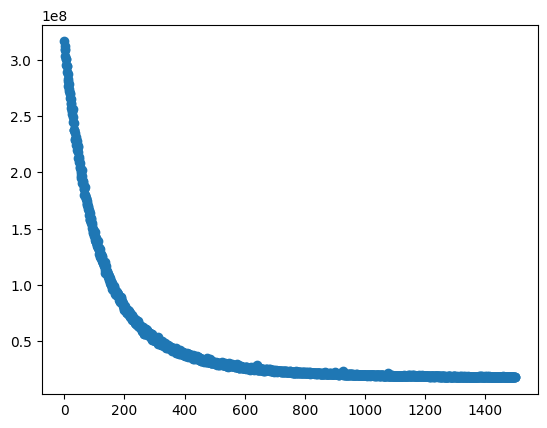

In [472]:
plt.scatter(np.arange(0,train_num,1), losses)

In [449]:
#from pyro.infer import MCMC, NUTS
#nuts_kernel = NUTS(model)
#mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=500)
#mcmc.run(data, T=8)
#mcmc.summary()


In [473]:
# Use Predictive to sample from posterior
from pyro.infer import Predictive


In [474]:
predictive = Predictive(model, guide=guide, num_samples=100)
samples = predictive(data, 8)
print(samples['z'].shape)
z_samples = samples['z'].float().mean(dim=0).squeeze()  # Shape: (100, N)

print(z_samples.shape)
print(z_samples)

torch.Size([100, 119, 1])
torch.Size([119])
tensor([0.6700, 0.7700, 0.7000, 0.7100, 0.7700, 0.6400, 0.7200, 0.5100, 0.6200,
        0.8600, 0.7400, 0.7500, 0.5700, 0.5600, 0.5700, 0.7000, 0.7000, 0.8600,
        0.6900, 0.6800, 0.5300, 0.5700, 0.7400, 0.6200, 0.6000, 0.8000, 0.7600,
        0.5900, 0.5800, 0.6400, 0.7000, 0.7100, 0.8000, 0.6300, 0.6000, 0.7100,
        0.4700, 0.8400, 0.5900, 0.6900, 0.6500, 0.6800, 0.5300, 0.8000, 0.8500,
        0.4800, 0.6900, 0.7500, 0.6000, 0.6500, 0.5700, 0.6800, 0.8600, 0.7300,
        0.6400, 0.6300, 0.7200, 0.8100, 0.8300, 0.7000, 0.6900, 0.7400, 0.5100,
        0.6700, 0.7300, 0.6700, 0.7400, 0.6700, 0.4400, 0.8000, 0.5400, 0.6200,
        0.7300, 0.8500, 0.7000, 0.6200, 0.7200, 0.7300, 0.6500, 0.6500, 0.7900,
        0.7900, 0.7300, 0.7000, 0.7800, 0.6800, 0.5600, 0.8200, 0.5800, 0.7000,
        0.6500, 0.6600, 0.5800, 0.6300, 0.6100, 0.7500, 0.7500, 0.6800, 0.5400,
        0.5600, 0.8400, 0.5400, 0.6300, 0.6200, 0.5700, 0.5600, 0.6900, 0.56

In [475]:
print(max(z_samples))
print(min(z_samples))

tensor(0.9000)
tensor(0.4400)
